# Version Identification

This notebook is designed to give an introduction to the Music Version Identification (VI) task. We first define the problem and discuss some use cases. Later, we talk about the issues that make this task a challenging one. Finally, we go through a successful VI algorithm while explaining the design decisions.

Note: This class is planned to introduce a number of techniques and methods that can be useful for other application scenarios.

This notebook is prepared by [Furkan Yesiler](mailto:furkan.yesiler@upf.edu) for Music Information Retrieval course of the Sound and Music Computing master program of UPF.

### Outline
1. **Introducing VI**
    1. Definition of the task
    2. Use cases
    3. Challenges
2. **Implementing a VI system**
    1. Feature extraction
    2. Tempo / timing invariance
    3. Pitch transposition invariance
    4. Adding temporal context
    5. Cross recurrence plots
    6. Similarity estimation via local alignment
3. **Evaluating similarity tasks**
4. **Experimenting on a dataset**
    1. Feature extraction
    2. Pairwise similarity estimation
    3. MAP computation for evaluation
5. **Possible improvements and future work**
6. **References**

## 1. Introducing VI
The first part of this lecture aims to give a brief overview of the task we will be dealing with.

### 1.A. Definition of the task
Version: any reinterpretation of an existing musical work

Although we choose to use the term ‘version’ to denote such reinterpretations, another widely-used term is ‘cover song’.

Serrà [1] classifies types of versions into 10 categories: remaster, instrumental, mashup, live performance, acoustic, demo, standard, medley, remix and quotation.

### 1.B. Use cases
The VI task was born to address a very particular need in the music industry: copyright management. Algorithms that find and retrieve near/exact duplicates (e.g. audio fingerprinting) demonstrate sufficiently high performances but they often fail when a version that is not in their database is queried. To handle such cases, we need to consider the musical characteristics of songs and incorporate musical domain knowledge into our systems.

We can group use cases into 3 categories:

* **Commercial use cases**: broadcast monitoring, copyright management
* **Music-related use cases**: defining a notion of music similarity
* **Personal / user-related use cases**: finding new versions of a favorite song

### 1.C. Challenges
Let's listen to some music to have some fresh ideas!

In [1]:
from IPython.display import HTML

s = """<table>
<tr>
<th>Version</th>
<th>Original</th>
<th>Version</th>
<th>Original</th>
</tr>
<tr>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/mNwtNA5KMD4?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/Vbg7YoXiKn0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/OW_JyjyUza0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/fNFzfwLM72c?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
</tr>
<tr>
<th>Version</th>
<th>Original</th>
<th>Version</th>
<th>Original</th>
</tr>
<tr>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/Mtij83oE0sg?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/izGwDsrQ1eQ?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/l7dizP92pW0?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
<td><iframe width="100" height="100" src="https://www.youtube.com/embed/CSvFpBOe8eY?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></td>
</tr>
</table>"""

HTML(s)

Version,Original,Version,Original
,,,
Version,Original,Version,Original
,,,


Pretty tough, huh?

We see that when artists perform a version, they can change pretty much everything about the original song's characteristics. Serrà [1] defines these 'modifiable musical characteristics' as  
1. Timbre
    * Due to production techniques
    * Due to instrumentation
2. Tempo
3. Timing
4. Structure
5. Key
6. Harmonization
7. Lyrics
8. Noise

## 2. Implementing a VI system
Now that we have some solid ideas about the task, we can start building a VI system while questioning the design decisions. The system we introduce here is proposed by Serrà et al. [2] with some modifications, and you can find the detailed explanation of all the steps in that paper. Although we can change some aspects of it to improve the performance, the goal here is to get you familiar with the thinking process when you face a novel task.

Below, we introduce a number of questions to decide our first steps.

- Is this a classification or a regression problem?
- How do you define similarity in the context of versions?
- What information should we extract from the audio?
- What are the advantages/disadvantages of audio features for this task?

For the next steps, we use demonstrate the fundamental components of the system on 3 songs, i.e. two songs that are versions of each other and one unrelated song.

### 2.A. Feature extraction
In order to estimate the similarity between two tracks, we need to extract relevant information from them. Considering the modifiable musical characteristics mentioned above, a good representation for this task should involve melodic or tonal information. Empirically, the Pitch Class Profiles (PCP) have been proven to be useful for this task, and here, we extract Harmonic PCP (HPCP) features from our tracks to get started.

In [2]:
use_pre_extracted_features = True  # this should be True if you don't have the audio files of the songs

import os
from itertools import permutations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from six.moves import cPickle as pickle
from sklearn.metrics.pairwise import euclidean_distances

if not use_pre_extracted_features:  # you need essentia and librosa installed to extract necessary features
    import essentia
    import essentia.standard as ess
    import librosa

In [3]:
def extract_hpcp(audio_path,
                 sample_rate=44100,
                 frame_size=4096,
                 hop_size=2048):
    """
    Function to extract HPCP vectors for a given audio path
    
    :param audio_path: path of the song
    :param sample_rate: sample rate for loading the audio
    :param frame_size: frame size for the HPCP computation
    :param hop_size: hop size for the HPCP computation
    :return: HPCP vector with shape 12xT
    """
    
    audio_vector = essentia.array(ess.MonoLoader(filename=audio_path, sampleRate=sample_rate)())

    frameGenerator = ess.FrameGenerator(audio_vector, frameSize=frame_size, hopSize=hop_size)

    window = ess.Windowing(type='hamming')

    spectrum = ess.Spectrum()

    spectralPeaks = ess.SpectralPeaks(sampleRate=sample_rate,
                                      minFrequency=40)

    spectralWhitening = ess.SpectralWhitening(sampleRate=sample_rate)

    hpcp = ess.HPCP(sampleRate=sample_rate,
                    harmonics=8)

    pool = essentia.Pool()

    for frame in frameGenerator:
        spectrum_mag = spectrum(window(frame))
        frequencies, magnitudes = spectralPeaks(spectrum_mag)
        w_magnitudes = spectralWhitening(spectrum_mag,
                                        frequencies,
                                        magnitudes)
        hpcp_vector = hpcp(frequencies, w_magnitudes)
        pool.add('tonal.hpcp',hpcp_vector)

    return pool['tonal.hpcp'].T
    
    
def plot_matrix(input_matrix, 
                xlabel='', 
                ylabel='', 
                title='',
                annotate_q_max=False):
    """
    A helper function to plot 2-D matrices
    
    :param input_matrix: any 2-D matrix to plot
    :param xlabel: label for the x-axis
    :param ylabel: label for the y-axis
    :param title: title for the plot
    """
    
    plt.pcolormesh(input_matrix)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if annotate_q_max:
        xy = np.array(np.where(input_matrix == np.max(input_matrix)))
        for i in range(xy.shape[1]):
            if i == 0:
                txt = 'Highest point: {:.1f}'.format(np.max(input_matrix))
            else:
                txt = ''
            plt.annotate(txt, 
                         xy=(xy[1, i], xy[0, i]), 
                         arrowprops=dict(facecolor='black', shrink=0), 
                         xytext=(1.1, 0.5), 
                         textcoords='axes fraction')
    plt.show()

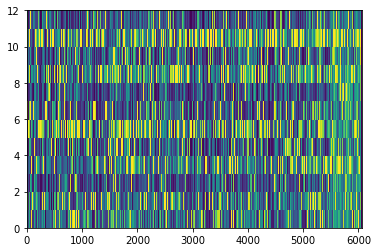

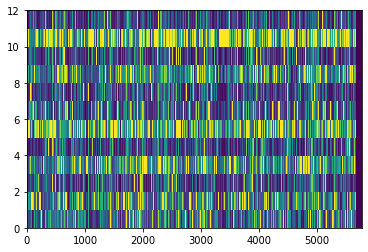

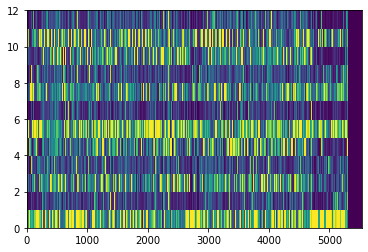

In [4]:
if use_pre_extracted_features:  # you may change this from the import cell if you have the audio files
    with open('./data/features_hpcp_3songs.pkl', 'rb') as f:
        hpcp_dict = pickle.load(f)
        pcp_1 = hpcp_dict['Song 1']
        pcp_2 = hpcp_dict['Song 2']
        pcp_3 = hpcp_dict['Song 3']
else:
    pcp_1 = extract_hpcp('./data/P_856.mp3')
    pcp_2 = extract_hpcp('./data/P_857.mp3')
    pcp_3 = extract_hpcp('./data/P_434.mp3')

plot_matrix(pcp_1)
plot_matrix(pcp_2)
plot_matrix(pcp_3)

### 2.B. Tempo / timing invariance
Changes in tempo or timing are among the most common alterations when performing a version. In order to deal with these cases, we can transform our HPCP features into beat-synchronous HPCP. This way, instead of having one PCP vector per frame, we get one PCP vector per beat.

In [5]:
def beat_sync(audio_path, 
              pcp, 
              sample_rate=44100):
    """
    Function for obtaining beat-synchronous PCP vectors
    
    :param audio_path: path of the song
    :param pcp: PCP vectors to beat-synchronize
    :param sample_rate: sample rate for loading the audio
    :return: beat-synchronous PCP vectors
    """
    
    audio_vector = ess.MonoLoader(filename=audio_path, sampleRate=sample_rate)()
    y_harmonic, y_percussive = librosa.effects.hpss(audio_vector)
    tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sample_rate)
    beat_sync_pcp = librosa.util.sync(pcp, beats, aggregate=np.median)
    
    return beat_sync_pcp

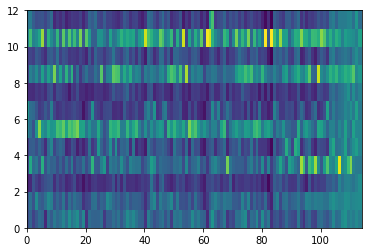

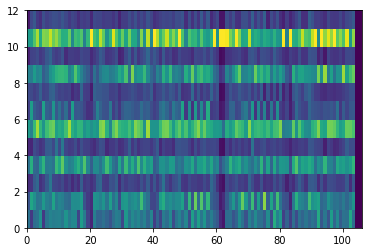

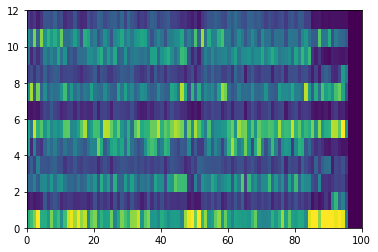

In [6]:
if use_pre_extracted_features:  # you may change this from the import cell if you have the audio files
    with open('./data/features_hpcp_bsync_3songs.pkl', 'rb') as f:
        hpcp_bsync_dict = pickle.load(f)
        pcp_bsync_1 = hpcp_bsync_dict['Song 1']
        pcp_bsync_2 = hpcp_bsync_dict['Song 2']
        pcp_bsync_3 = hpcp_bsync_dict['Song 3']
else:
    pcp_bsync_1 = beat_sync('./data/P_856.mp3', pcp_1)
    pcp_bsync_2 = beat_sync('./data/P_857.mp3', pcp_2)
    pcp_bsync_3 = beat_sync('./data/P_434.mp3', pcp_3)

plot_matrix(pcp_bsync_1)
plot_matrix(pcp_bsync_2)
plot_matrix(pcp_bsync_3)

### 2.C. Pitch transposition invariance
Another highly common musical modification when performing a version is to transpose the original song few semitones lower or higher. In order to deal with this, we can use a technique called 'optimal transposition index'. This method finds the optimal amount of transposition in pitch dimension needed that would make two songs the most similar.

In [7]:
def optimal_transposition_index(pcp_1, 
                                pcp_2):
    """
    Function for calculating and applying optimal transposition index
    
    :param pcp_1: PCP vectors of the query song
    :param pcp_2: PCP vectors of the reference song
    :return: the original PCP vectors of the query song and the transposed PCP vectors of the reference song 
    """
    
    glob_pcp_1 = np.sum(pcp_1, axis=1)
    glob_pcp_1 /= np.max(glob_pcp_1)
    
    glob_pcp_2 = np.sum(pcp_2, axis=1)
    glob_pcp_2 /= np.max(glob_pcp_2)
    
    scores = [np.dot(glob_pcp_1, np.roll(glob_pcp_2, i, axis=0)) for i in range(12)]
    
    return pcp_1, np.roll(pcp_2, np.argmax(scores), axis=0)

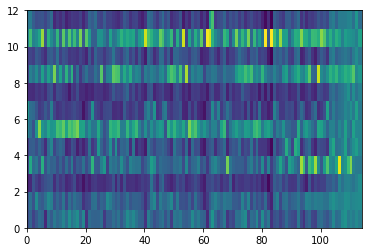

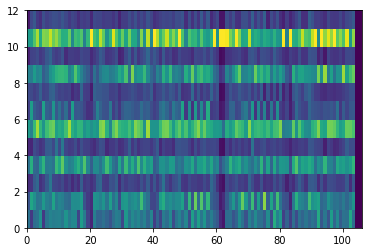

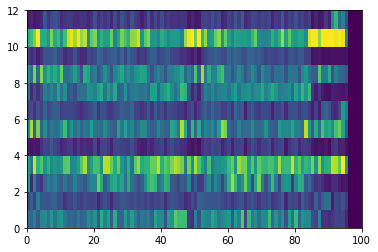

In [8]:
do_bsync = 1

if do_bsync:
    pcp_oti_1, pcp_oti_2 = optimal_transposition_index(pcp_bsync_1, pcp_bsync_2)
    pcp_oti_1, pcp_oti_3 = optimal_transposition_index(pcp_bsync_1, pcp_bsync_3)
else:
    pcp_oti_1, pcp_oti_2 = optimal_transposition_index(pcp_1, pcp_2)
    pcp_oti_1, pcp_oti_3 = optimal_transposition_index(pcp_1, pcp_3)

plot_matrix(pcp_oti_1)
plot_matrix(pcp_oti_2)
plot_matrix(pcp_oti_3)

### 2.D. Adding temporal context with state space embedding
Our method for estimating the similarity between two songs is based on estimating their frame-level similarities. We can estimate the entire pairwise frame similarities individually but we need to consider that the songs we work with are examples of time series. The way PCP vectors per frame (or per beat) evolve over time is highly important. To incorporate that information, we can use a technique called 'state space embedding'. 

This technique concatenates a given number of the future frames to our current frame. By doing this, our first vector in the time dimension will not only include the PCP vector of the first frame, *x_n*, but also the PCP vectors of *m-1* (m is a hyperparameter) consecutive future frames, e.g. (*x_n, x_(n+1), x_(n+2), .. , x_(n+(m-1))*).

In [9]:
def state_space_embedding(pcp, 
                          t=1, 
                          m=10):
    """
    Function for creating state space embeddings for given PCP vectors
    
    :param pcp: input PCP vectors
    :param t: time delay
    :param m: embedding dimension
    :return: state space embeddings for the input PCP vectors
    """
    
    for i in range(m-1):                                                                                
        if i == 0:
            tmp = np.concatenate((pcp, np.roll(pcp, -(i+1))))
        else:
            tmp = np.concatenate((tmp, np.roll(pcp, -(i+1))))
    return tmp[:, : -(m-1)]

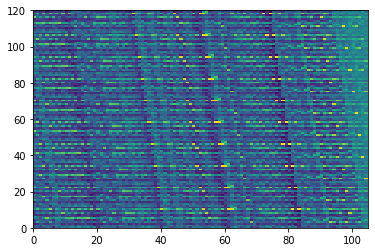

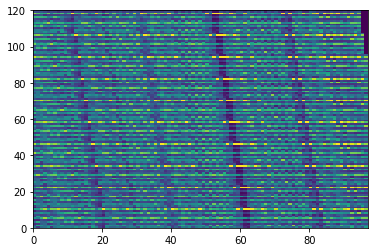

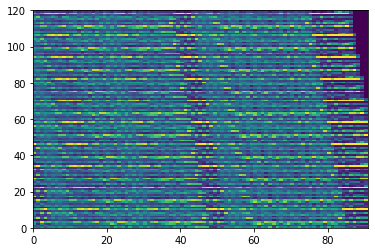

In [10]:
pcp_sse_1 = state_space_embedding(pcp_oti_1)
pcp_sse_2 = state_space_embedding(pcp_oti_2)
pcp_sse_3 = state_space_embedding(pcp_oti_3)

plot_matrix(pcp_sse_1)
plot_matrix(pcp_sse_2)
plot_matrix(pcp_sse_3)

### 2.E. Cross Recurrence Plots
Another common modification in versions compared to the original songs is the change in structure. For instance, an artist may choose to repeat the intro section or skip the third repetition of the chorus at the end of the song. To deal with this, for example, we can compare the first frame of the first song with not only the first frame of the second song but with all the frames of the second song and so on.

In order to compare two songs frame by frame to estimate their similarity, we need a distance metric. In this example, we use Euclidean distance. If these distances are above a threshold, we will put 1 on our cross recurrence plot, and 0 otherwise. Instead of setting a fixed distance threshold, we set a fixed *percentage* threshold (k). With this, the number of 1s in each row and column won't exceed *k * (# of frames in song 2)* and *k * (# of frames in song 1)*. 

Finally, in order to say ith frame of song 1 is a neighbor of (or similar to) jth frame of song 2 (crp_ij equals 1), both these frames should be neighbors of each other.

In [11]:
def cross_recurrence_plot(pcp_1, 
                          pcp_2, 
                          k=10):
    """
    Function for computing cross recurrence plot given two PCP vectors.
    Taken from https://github.com/albincorreya/ChromaCoverId and modified.
    
    :param pcp_1: PCP vectors of the query song
    :param pcp_2: PCP vectors of the reference song
    :param k: the percentage for the distance threshold (e.g. k=10 implies 10%)
    :return: cross recurrence plot of the two input vectors
    """
    
    dist = euclidean_distances(pcp_1.T, pcp_2.T)
    t_dist = dist.T
    eph_x = np.percentile(dist, k, axis=1)
    eph_y = np.percentile(t_dist, k, axis=1)
    x = eph_x[:,None] - dist
    y = eph_y[:,None] - t_dist
    
    x = np.piecewise(x, [x<0, x>=0], [0,1])
    y = np.piecewise(y, [y<0, y>=0], [0,1])
    
    crp = x*y.T
    
    return crp

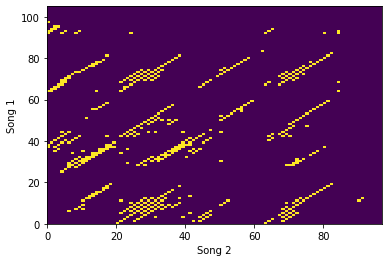

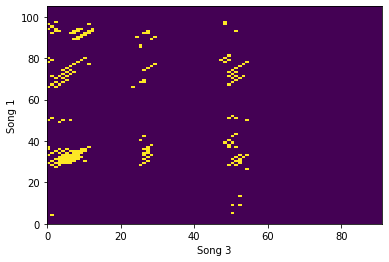

In [12]:
crp_1 = cross_recurrence_plot(pcp_sse_1, pcp_sse_2)
crp_2 = cross_recurrence_plot(pcp_sse_1, pcp_sse_3)

plot_matrix(crp_1, xlabel='Song 2', ylabel='Song 1')
plot_matrix(crp_2, xlabel='Song 3', ylabel='Song 1')

### 2.F. Similarity estimation via local alignment
The cross recurrence plots show us the frames of the song 1 that are similar to the frames of song 2 but we still need to quantify the similarity estimation. A common method used in many other tasks is to use Dynamic Time Warping (DTW). This technique tries to find a global alignment between two inputs but due to changes in tempo, timing and structure, it may not be a reasonable approach for our task.

The alternative we use in this example is based on Smith-Waterman algorithm [3] which finds the local alignments in a given cross recurrence plot (or a similarity matrix). Specifically, we use a variant of this algorithm that is proposed by Serrà et al. [2] called 'Q_max'.

In [13]:
def q_max(crp, 
          normalize_by_length=True):
    """
    Function for similarity estimation given a cross recurrence plot.
    Taken from https://github.com/albincorreya/ChromaCoverId and modified.
    
    :param crp: cross recurrence plot of two songs
    :param normalize_by_length: whether to normalize the q_max score by the length of the reference song
    :return: distance between two songs, resulting local alignment matrix 
    """
    
    len_x, len_y = crp.shape[0], crp.shape[1]
    
    local_alignment_matrix = np.zeros(crp.shape)

    for i in range(2, len_x):
        for j in range(2, len_y):
            if int(crp[i,j]) == 1:
                local_alignment_matrix[i][j] = max([local_alignment_matrix[i-1][j-1], 
                                                    local_alignment_matrix[i-2][j-1], 
                                                    local_alignment_matrix[i-1][j-2]]
                                                  ) + 1
            else:
                local_alignment_matrix[i][j] = max([0,
                                                    (local_alignment_matrix[i-1][j-1] - distruption_penalty(crp[i-1][j-1])),
                                                    (local_alignment_matrix[i-2][j-1] - distruption_penalty(crp[i-2][j-1])),
                                                    (local_alignment_matrix[i-1][j-2] - distruption_penalty(crp[i-1][j-2]))]
                                                  )
    
    q_max_score = np.max(local_alignment_matrix)
    
    if normalize_by_length:
        distance = np.divide(np.sqrt(len_y), q_max_score + 1e-8)
    else:
        distance = np.divide(1, q_max_score + 1e-8)
    
    return distance, local_alignment_matrix

def distruption_penalty(value, 
                        penalty_o=0.5, 
                        penalty_e=0.5):
    """
    Function for determining the distruption penalty
    
    :param value: input value
    :param penalty_o: penalty for distruption onset
    :param penalty_e: penalty for distruption extention
    :return: penalty to apply
    """
    
    return penalty_o if value == 1 else penalty_e

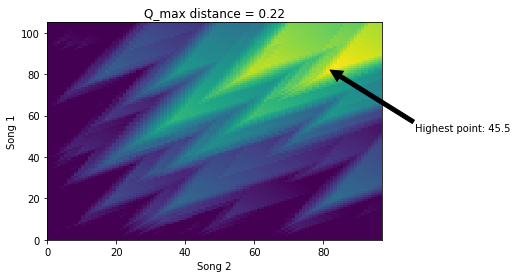

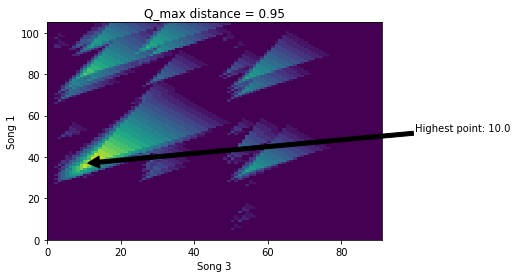

In [14]:
q_max_dist_1, mat_1 = q_max(crp_1)
q_max_dist_2, mat_2 = q_max(crp_2)

plot_matrix(mat_1, title='Q_max distance = {:.2f}'.format(q_max_dist_1), xlabel='Song 2', ylabel='Song 1', annotate_q_max=True)
plot_matrix(mat_2, title='Q_max distance = {:.2f}'.format(q_max_dist_2), xlabel='Song 3', ylabel='Song 1', annotate_q_max=True)

## 3. Evaluating similarity tasks
The evaluation metrics used for similarity tasks differ from the ones used for classification and regression tasks. As seen above, the common case is to find a distance or a similarity score between a query and a reference. After obtaining all pairwise distances (or similarity scores), we sort these values to find which of the reference items are closer to a given query. The evaluation metrics estimate the performance of a system based on these sorted distances.

The commonly used evaluation metrics for VI are mean average precision (MAP), mean rank of first relevant item (MR1) and the number of queries that have a relevant item in their first rank (Top-1).

For this example, we focus on MAP.

In [15]:
def compute_map(y_true, y_pred):
    """
    Function for computing mean average precision
    
    :param y_true: ground truth relevance matrix
    :param y_pred: distances
    :return: mean average precision
    """
    y_pred += np.diag(np.ones(y_true.shape[0]) * float('inf'))
    
    sorted_idx = y_pred.argsort()
    gathered_idx = np.take_along_axis(y_true, sorted_idx, axis=1)
    
    pos = np.arange(1, y_true.shape[0]+1).reshape(1, -1)
    prec = np.cumsum(gathered_idx, axis=1) / pos
    mask = (gathered_idx > 0).astype(np.float)
    av_prec = np.sum(prec * mask, 1) / np.sum(y_true, 1)
    av_prec = av_prec[np.sum(y_true, axis=1) > 0]
    
    return av_prec.mean()

## 4. Experimenting on a dataset
Now that we have a working system and an evaluation metric to estimate its performance, we can test our system on a small dataset. For this, we can consider two stages: feature extraction, pairwise similarity estimation and MAP computation.

Our code below reads all the files in our data folder and extracts beat-synchronous HPCPs. Later, we compute all pairwise distances by applying, in order, optimal transposition index and state space embedding to obtain a cross recurrence plot. Using this, we calculate Q_max distance score of each pair of songs in the dataset.

### 4.A. Feature extraction

In [16]:
if use_pre_extracted_features:  # you may change this from the import cell if you have the audio files
    with open('./data/features_VI.pkl', 'rb') as f:
        feature_dict = pickle.load(f)
    features = [feature_dict[key] for key in feature_dict.keys()]
    filenames = [key for key in feature_dict.keys()]

else:
    paths = []
    filenames = []
    for path, subdirs, files in os.walk('./data/'):
        for file in files:
            if file.endswith('mp3'):
                paths.append(os.path.join(path, file))
                filenames.append(Path(file).stem)

    features = []
    for i in range(len(paths)):
        tmp_pcp = extract_hpcp(paths[i])
        tmp_pcp = beat_sync(paths[i], tmp_pcp)
        features.append(tmp_pcp)

### 4.B. Pairwise similarity estimation

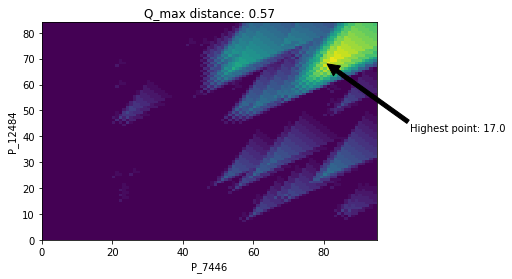

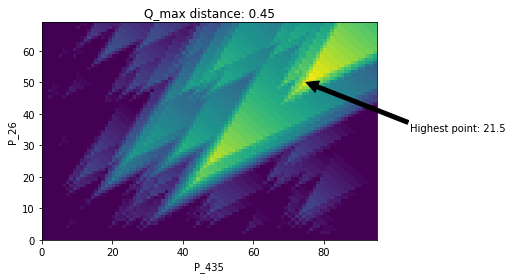

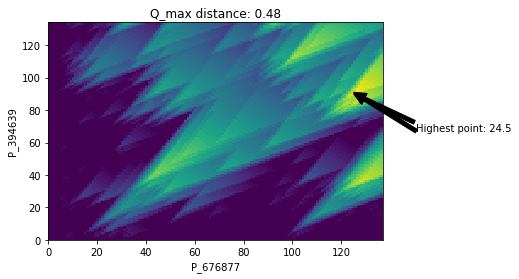

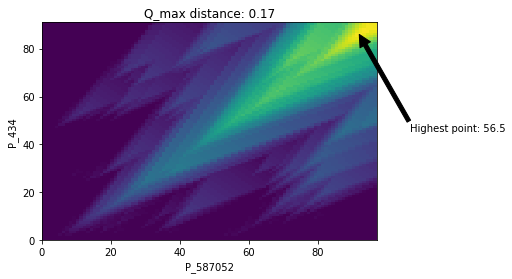

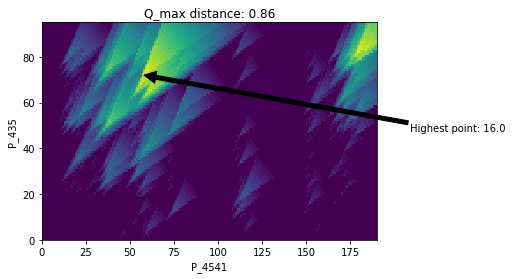

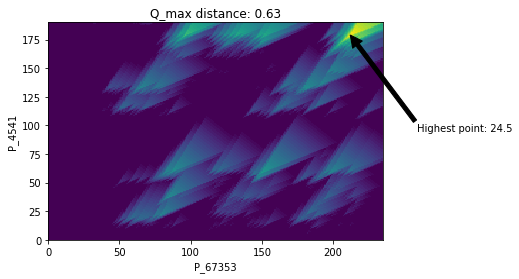

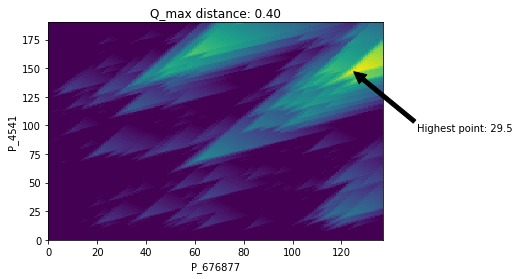

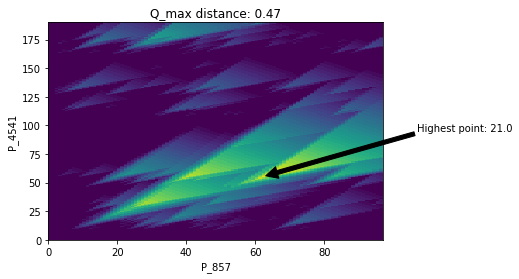

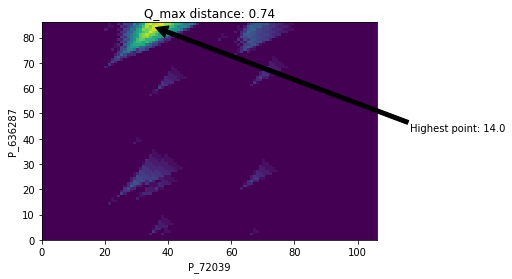

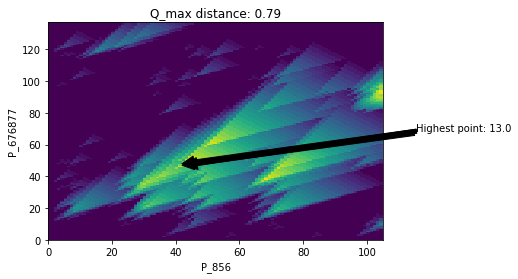

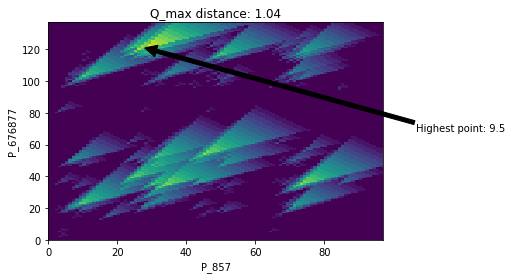

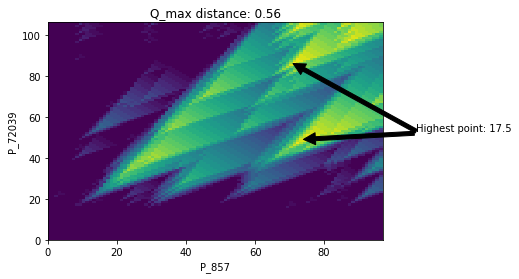

In [17]:
num_of_songs = len(features)

all_perms = list(permutations(range(num_of_songs), 2))

all_dist = np.zeros((num_of_songs, num_of_songs))

for perm in all_perms:
    idx_1, idx_2 = perm
    
    tmp_1, tmp_2 = optimal_transposition_index(features[idx_1], features[idx_2])
    tmp_1, tmp_2 = state_space_embedding(tmp_1), state_space_embedding(tmp_2)
    
    tmp_crp = cross_recurrence_plot(tmp_1, tmp_2)
    
    tmp_q_max, tmp_local_alignment_matrix = q_max(tmp_crp)
    
    all_dist[idx_1, idx_2] = tmp_q_max
    
    if idx_1 < idx_2 and np.random.rand(1) < 0.08:
        plot_matrix(tmp_local_alignment_matrix, 
                    xlabel=filenames[idx_2], 
                    ylabel=filenames[idx_1], 
                    title='Q_max distance: {:.2f}'.format(tmp_q_max),
                    annotate_q_max=True)


### 4.C. MAP computation for evaluation

In [18]:
label_dict = {'P_4541': 0, 'P_160135': 0, 'P_394639': 0, 
              'P_7446': 1, 'P_72039': 1, 'P_67353': 1,
              'P_434': 2, 'P_435': 2, 'P_587052': 2,
              'P_856': 3, 'P_857': 3, 'P_636287': 3,
              'P_26': 4, 'P_676877': 4, 'P_12484': 4}

labels = np.array([label_dict[filenames[i]] for i in range(len(filenames))])

y_true = ((euclidean_distances(labels.reshape(-1, 1)) < 0.5).astype(np.long) * (1 - np.eye(labels.shape[0]))).astype(np.long)

In [19]:
y_true

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]])

In [20]:
print('Mean average precision is {:.3f}'.format(compute_map(y_true, all_dist)))

Mean average precision is 0.826


## 5. Possible improvements and future work
As we see from the performance score, the algorithm works pretty good for our dataset but this should not keep us from questioning the limitations of it.

Here, we list some of the potential problems of the proposed system:
* **Amount of computational resources needed (scalability):** Since the algorithm includes some computationally heavy techniques and works only by comparing two songs at a time, increasing the size of the features or amount of songs in our dataset makes this system not scalable to thousands (or millions) of songs.
* **Using PCP as the features:** PCP features are proven to work better than other features for this task but they may perform poorly for the cases where rhythmic or melodic characteristics are the most distinctive.
* **Key changes during the song:** Although OTI provides a good solution for handling the pitch transposition cases, it may not demonstrate sufficient performance when there are modulations of key changes in one song.


## 6. References
[1] [Joan Serrà. Identification of Versions of the Same Musical Composition by Processing Audio Descriptions. PhD thesis, Universitat Pompeu Fabra, Spain, 2011.](https://theses.eurasip.org/media/theses/documents/serra-joan-identification-of-versions-of-the-same-musical-composition-by-processing-audio-descriptions.pdf)

[2] [Joan Serrà, Xavier Serra, and Ralph G. Andrzejak. Cross recurrence quantification for cover song identification. New Journal of Physics, 11(9):093017, 2009.](https://iopscience.iop.org/article/10.1088/1367-2630/11/9/093017)

[3] [Temple F. Smith and Michael S. Waterman. Identification of common molecular subsequences. Journal of Molecular Biology, 147(1):195–197, 1981.](https://www.sciencedirect.com/science/article/abs/pii/0022283681900875)